In [1]:
import arviz as az
import pymc4 as pm
import tensorflow as tf
import pandas as pd

In [2]:
data = pd.read_csv('data/efron-morris-75-data.tsv', sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T

In [3]:
N = len(hits)

@pm.model
def baseball_model():
    phi = yield pm.Uniform("phi", 0, 1)
    
    kappa_log = yield pm.Exponential('kappa_log', rate=1.5)
    kappa = yield pm.Deterministic('kappa', tf.math.exp(kappa_log))
    
    thetas = yield pm.Beta('thetas', phi * kappa, (1 - phi) * kappa, plate=N)
    y = yield pm.Binomial('y', total_count=tf.constant(at_bats, dtype=tf.float32), probs=thetas, observed=tf.constant(hits, dtype=tf.float32))

In [4]:
%time trace =  pm.inference.utils.trace_to_arviz(*pm.inference.sampling.sample(baseball_model(), num_chains=128))

CPU times: user 3min 25s, sys: 25.1 s, total: 3min 50s
Wall time: 1min 19s


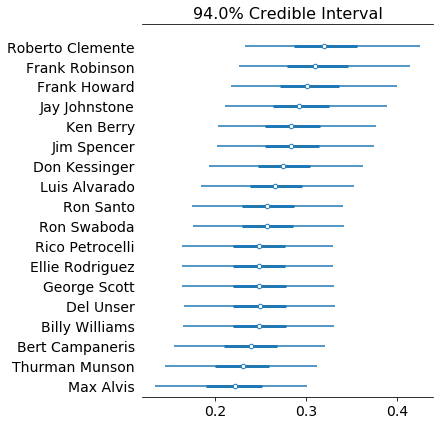

In [5]:
player_names = data.apply(lambda x: x.FirstName + ' ' + x.LastName, axis=1)
_, ax = az.plot_forest(trace, var_names='baseball_model/thetas', combined=True)
ax[0].set_yticklabels(player_names.tolist()[-1::-1]);